In [1]:
#import packages for multiple regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib notebook

In [2]:
#set working directory
os.chdir('C:/Users/siree/OneDrive/Desktop/WGU/D208/D208_Files')

In [3]:
#getting working directory
cwd = os.getcwd()
print(cwd)

C:\Users\siree\OneDrive\Desktop\WGU\D208\D208_Files


In [4]:
#load the dataset
data = pd.read_csv('churn_clean.csv')

In [ ]:
#### C1: DATA CLEANING ######

In [5]:
data_cleaned = data.copy()

In [6]:
#identify missing values
print(data_cleaned.isnull().sum())

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [7]:
#Impute missing values with mean for numerical columns and most frequent for categorical columns
numeric_features = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data_cleaned.select_dtypes(include=['object']).columns

In [8]:
#Impute numerical features
num_imputer = SimpleImputer(strategy='mean')
data_cleaned[numeric_features] = num_imputer.fit_transform(data_cleaned[numeric_features])

In [9]:
#Impute categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_features] = cat_imputer.fit_transform(data_cleaned[categorical_features])

In [10]:
#Detect outliers using Z-score
def detect_outliers(df, features):
    outlier_indices = []
    for feature in features:
#Calculate the Z-score
        z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
#find outliers
        outliers = list(np.where(z_scores > 3)[0])
        outlier_indices.extend(outliers)
    return list(set(outlier_indices))

In [11]:
#List of numerical features to check for outliers
outlier_indices = detect_outliers(data_cleaned, numeric_features)

In [12]:
#Remove outliers
outliers = data_cleaned.index.isin(outlier_indices)
data_cleaned = data_cleaned[~outliers].copy()

In [13]:
#Remove irrelevant columns
irrelevant_columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'Email', 'City', 'State', 'County', 'Lat', 'Lng', 'Zip', 'Job', 'TimeZone', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8']
columns_to_drop = [col for col in irrelevant_columns if col in data_cleaned.columns]
data_cleaned.drop(columns=columns_to_drop, inplace=True)

In [14]:
print(data_cleaned.head())

   Population      Area  Children   Age    Income        Marital  Gender  \
1     10446.0     Urban       1.0  27.0  21704.77        Married  Female   
2      3735.0     Urban       4.0  50.0   9609.57        Widowed  Female   
3     13863.0  Suburban       1.0  48.0  18925.23        Married    Male   
4     11352.0  Suburban       0.0  83.0  40074.19      Separated    Male   
5     17701.0     Urban       3.0  83.0  22660.20  Never Married  Female   

  Churn  Outage_sec_perweek  Contacts  ...  OnlineBackup DeviceProtection  \
1   Yes           11.699080       0.0  ...            No               No   
2    No           10.752800       0.0  ...            No               No   
3    No           14.913540       2.0  ...            No               No   
4   Yes            8.147417       2.0  ...            No               No   
5    No            8.420993       3.0  ...           Yes              Yes   

  TechSupport StreamingTV StreamingMovies PaperlessBilling  \
1          No     

In [15]:
#Convert categorical variables to numerical using one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, drop_first = True)

In [16]:
#VIF 
X = data_cleaned.drop(columns=['MonthlyCharge'])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                                  feature          VIF
0                              Population     1.527826
1                                Children     3.589264
2                                     Age     9.129743
3                                  Income     3.325366
4                      Outage_sec_perweek    12.419506
5                                Contacts     2.094705
6                    Yearly_equip_failure     1.417359
7                                  Tenure  2147.888737
8                       Bandwidth_GB_Year  2691.975383
9                           Area_Suburban     2.004334
10                             Area_Urban     1.997335
11                        Marital_Married     1.910360
12                  Marital_Never Married     1.937996
13                      Marital_Separated     1.962220
14                        Marital_Widowed     1.979220
15                            Gender_Male     2.455819
16                       Gender_Nonbinary     1.047876
17        

In [ ]:
#### C2: SUMMARY STATISTIC ##############

In [17]:
summary_stats = data_cleaned.describe()
print(summary_stats)

         Population     Children          Age         Income  \
count   8950.000000  8950.000000  8950.000000    8950.000000   
mean    8508.409274     1.941453    53.161341   38329.400298   
std    11759.988903     1.890668    20.634274   25123.528844   
min        0.000000     0.000000    18.000000     348.670000   
25%      727.250000     0.000000    35.000000   19041.117500   
50%     2750.000000     1.000000    53.000000   32778.475000   
75%    11838.750000     3.000000    71.000000   52280.437500   
max    52967.000000     8.000000    89.000000  124025.100000   

       Outage_sec_perweek     Contacts  Yearly_equip_failure       Tenure  \
count         8950.000000  8950.000000           8950.000000  8950.000000   
mean            10.009065     0.941676              0.374749    34.423473   
std              2.926500     0.900798              0.582945    26.445276   
min              1.144796     0.000000              0.000000     1.005104   
25%              8.031398     0.000000

In [18]:
categorical_columns = data_cleaned.select_dtypes(include=['uint8']).columns
for column in categorical_columns:
    print(f"\nValue counts for {column}:")
    print(data_cleaned[column].value_counts())


Value counts for Area_Suburban:
0    5956
1    2994
Name: Area_Suburban, dtype: int64

Value counts for Area_Urban:
0    5978
1    2972
Name: Area_Urban, dtype: int64

Value counts for Marital_Married:
0    7251
1    1699
Name: Marital_Married, dtype: int64

Value counts for Marital_Never Married:
0    7197
1    1753
Name: Marital_Never Married, dtype: int64

Value counts for Marital_Separated:
0    7146
1    1804
Name: Marital_Separated, dtype: int64

Value counts for Marital_Widowed:
0    7122
1    1828
Name: Marital_Widowed, dtype: int64

Value counts for Gender_Male:
0    4700
1    4250
Name: Gender_Male, dtype: int64

Value counts for Gender_Nonbinary:
0    8743
1     207
Name: Gender_Nonbinary, dtype: int64

Value counts for Churn_Yes:
0    6564
1    2386
Name: Churn_Yes, dtype: int64

Value counts for Techie_Yes:
0    7452
1    1498
Name: Techie_Yes, dtype: int64

Value counts for Contract_One year:
0    7061
1    1889
Name: Contract_One year, dtype: int64

Value counts for Con

In [ ]:
######## C3: UNIVARIATE AND BIVARIATE ########

In [19]:
#List of variables
dependent_var = 'MonthlyCharge'
quantitative_vars = ['Age', 'Income', 'Outage_sec_perweek', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
categorical_vars = ['Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

In [20]:
encoded_categorical_vars = [col for col in data.columns if col.startswith(('Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'))]

<IPython.core.display.Javascript object>


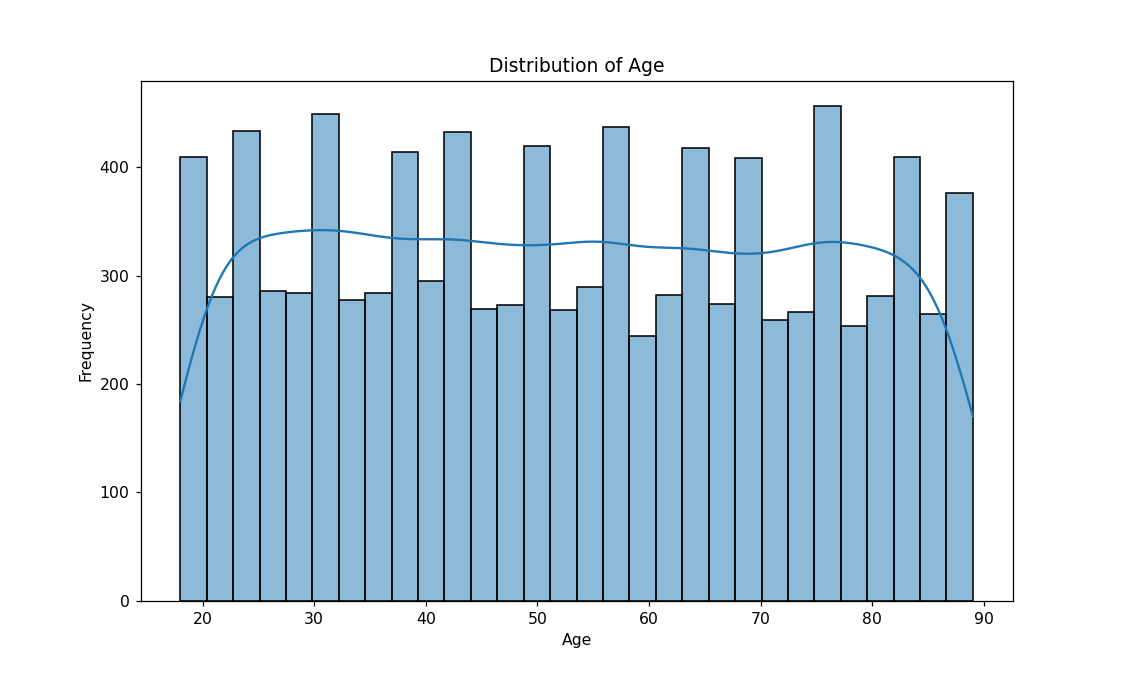

<IPython.core.display.Javascript object>


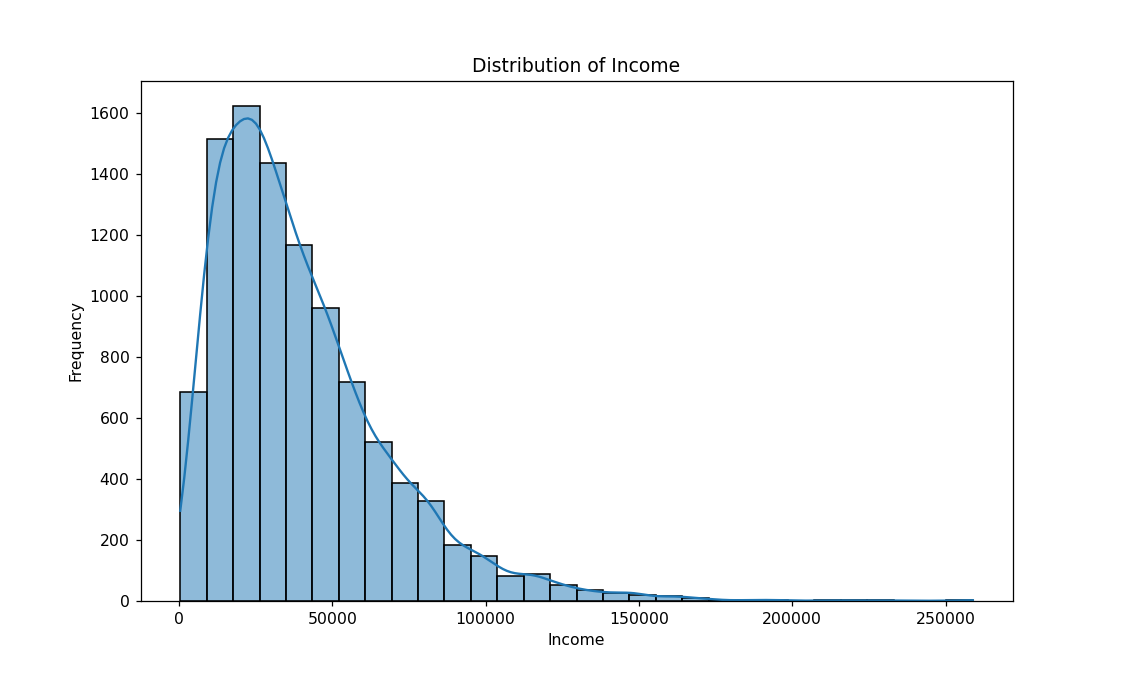

<IPython.core.display.Javascript object>


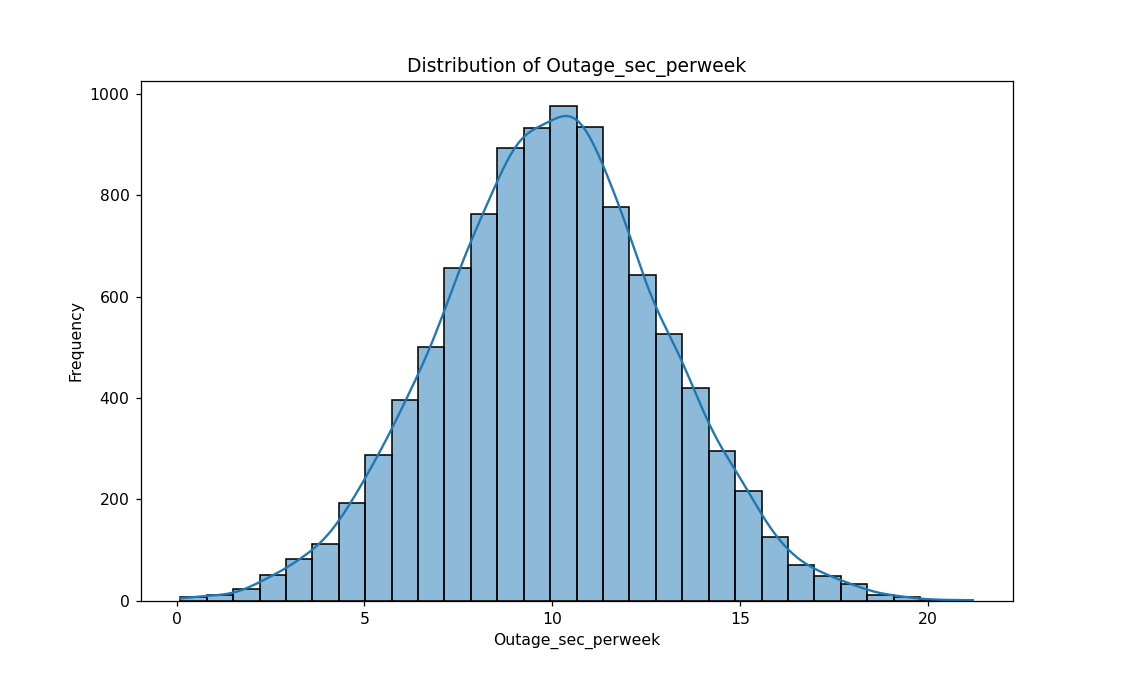

<IPython.core.display.Javascript object>


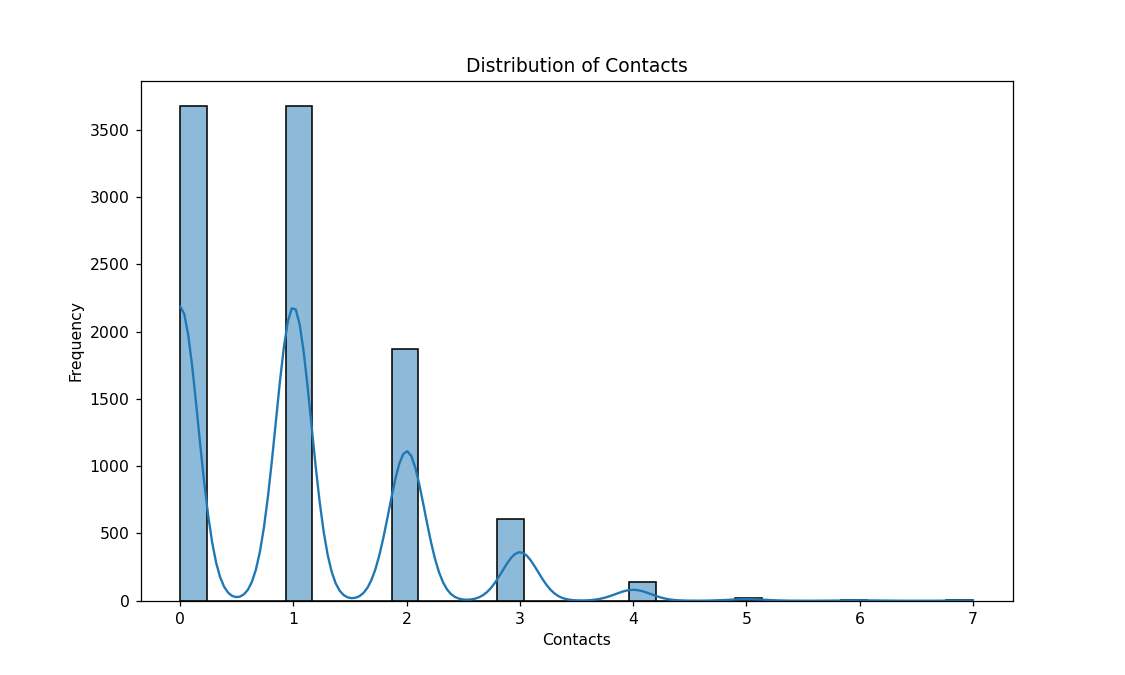

<IPython.core.display.Javascript object>


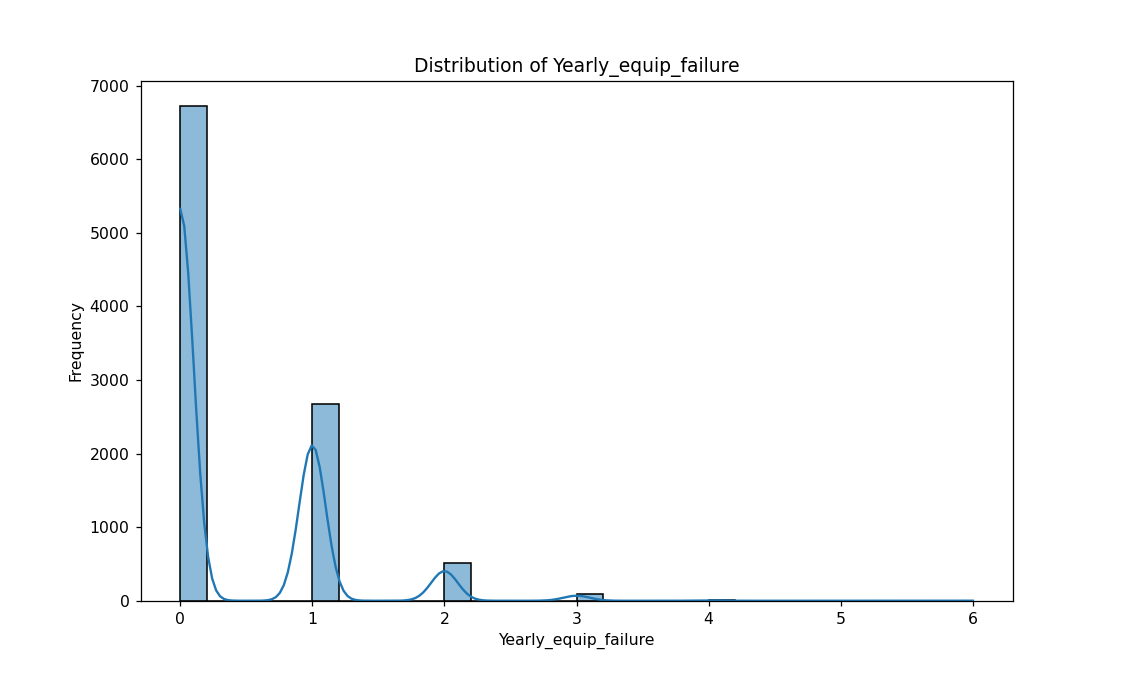

<IPython.core.display.Javascript object>


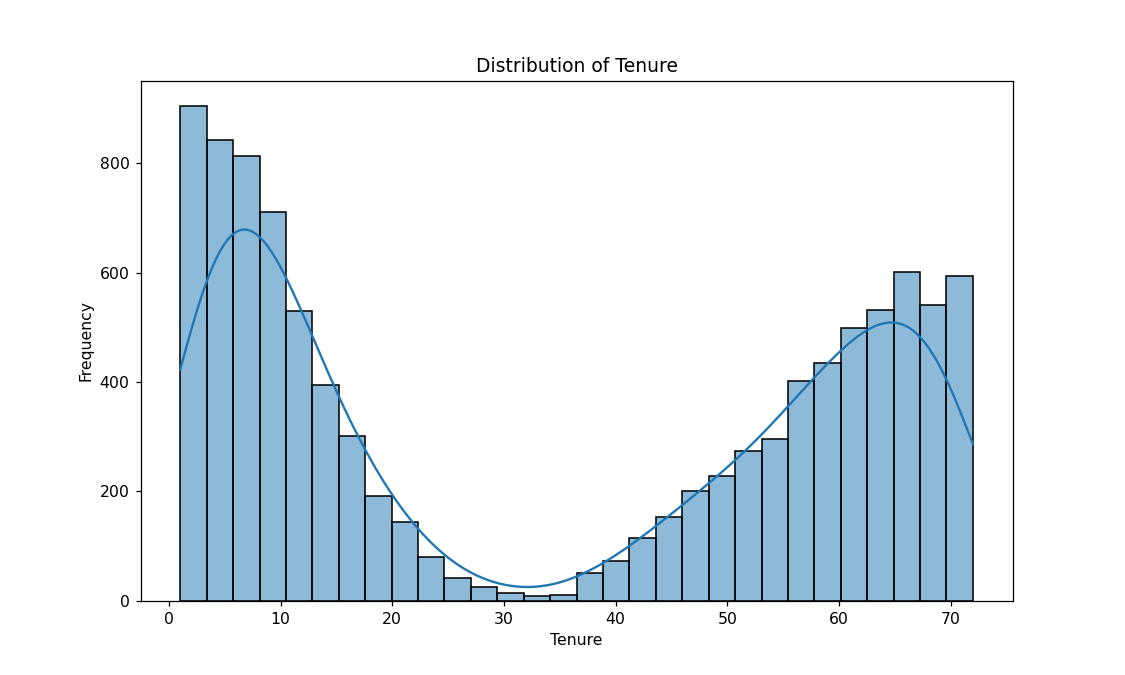

<IPython.core.display.Javascript object>


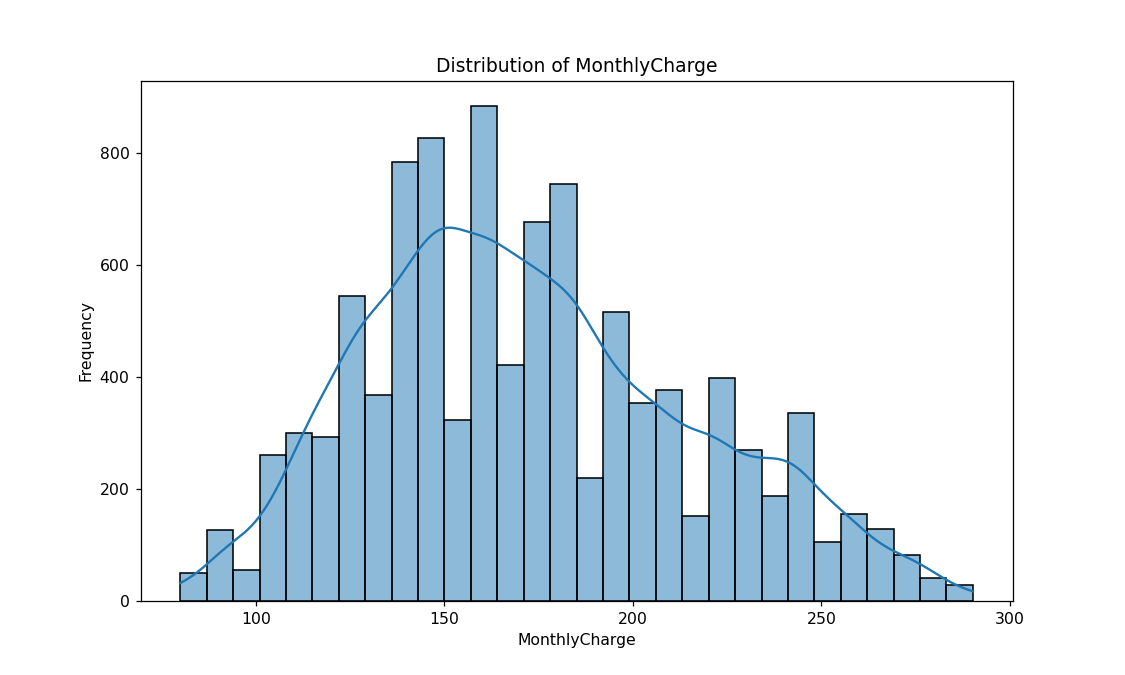

<IPython.core.display.Javascript object>


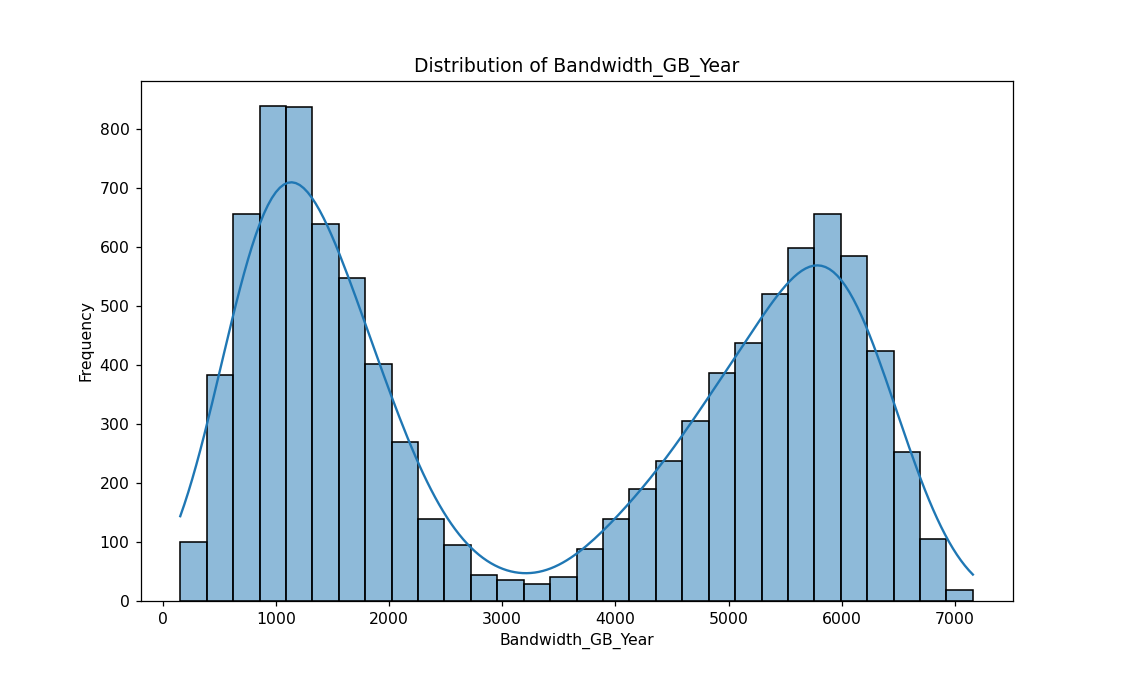

In [21]:
#Plotting histograms for quantitative variables
for var in quantitative_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[var], bins=30, kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

<IPython.core.display.Javascript object>


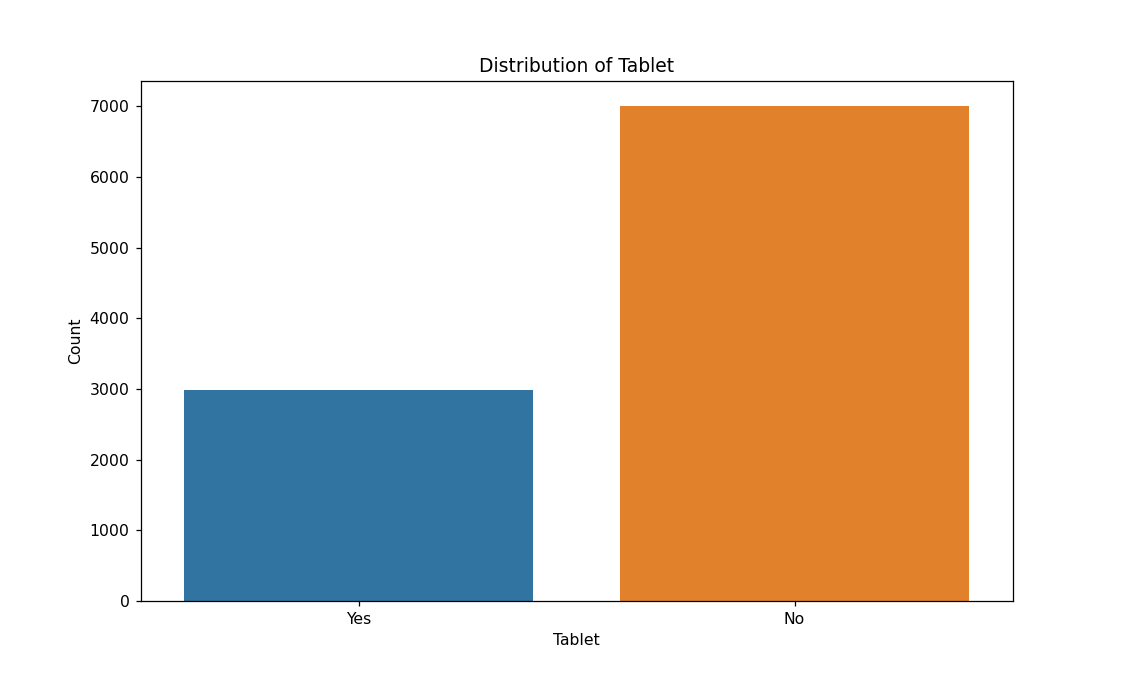

<IPython.core.display.Javascript object>


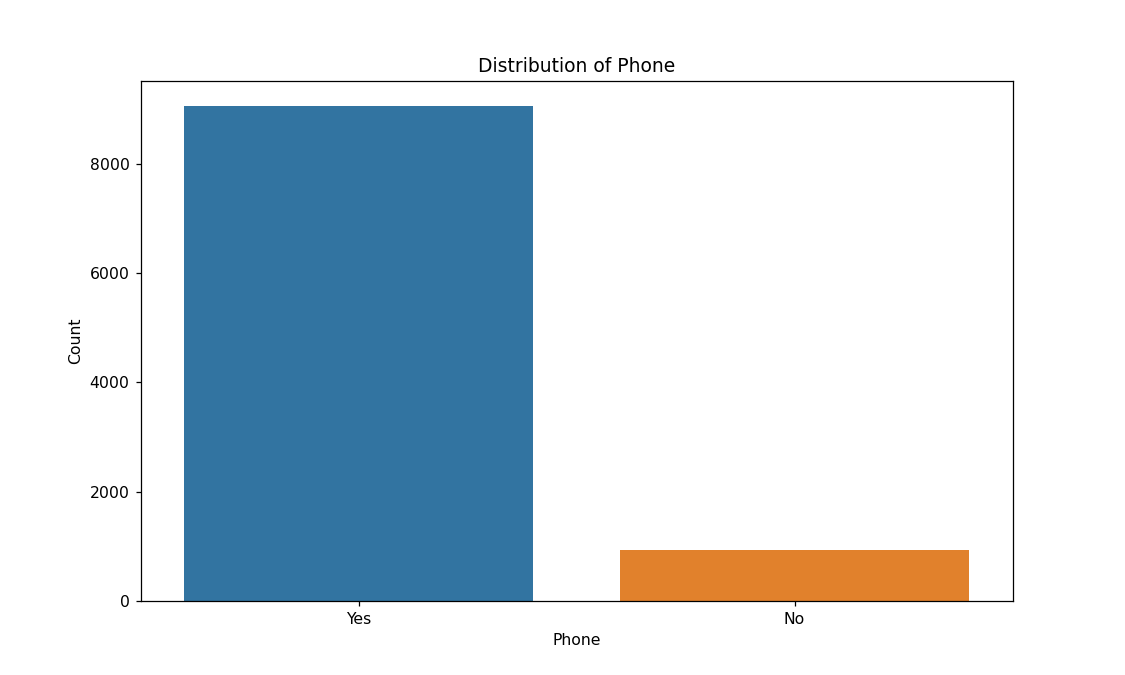

<IPython.core.display.Javascript object>


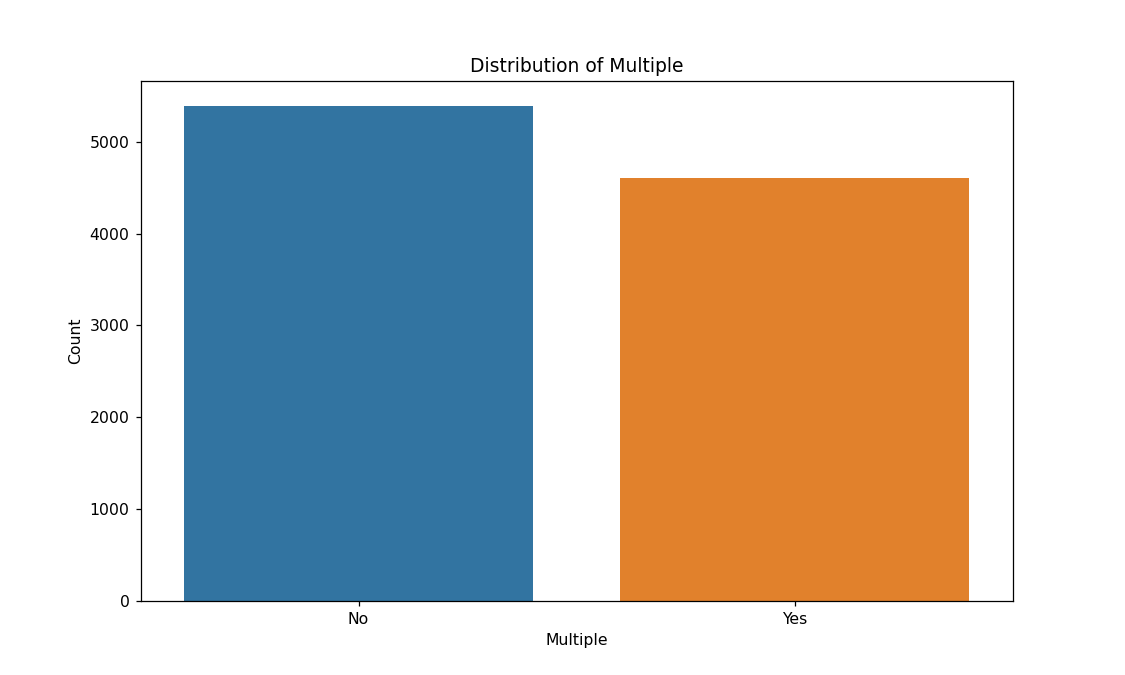

<IPython.core.display.Javascript object>


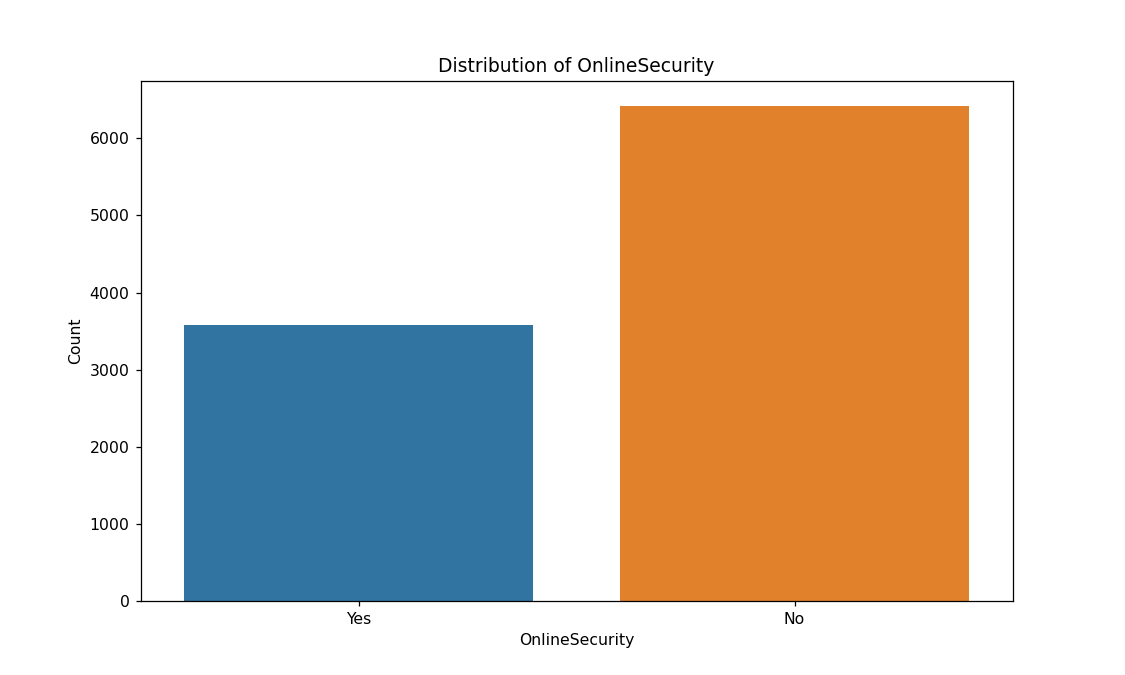

<IPython.core.display.Javascript object>


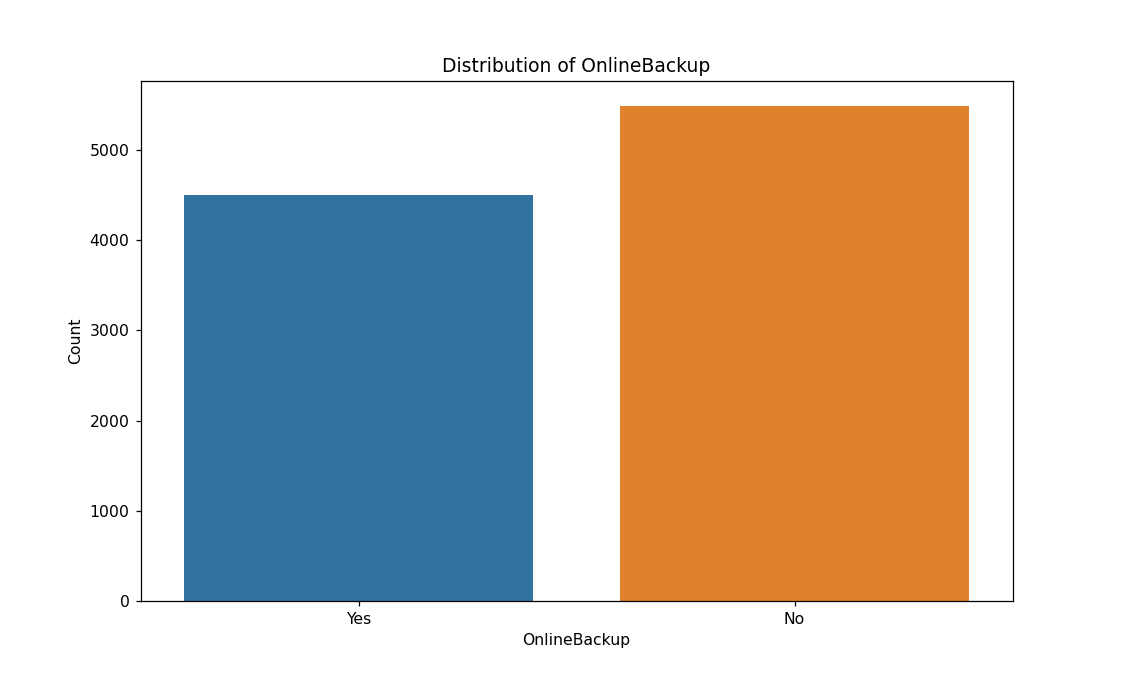

<IPython.core.display.Javascript object>


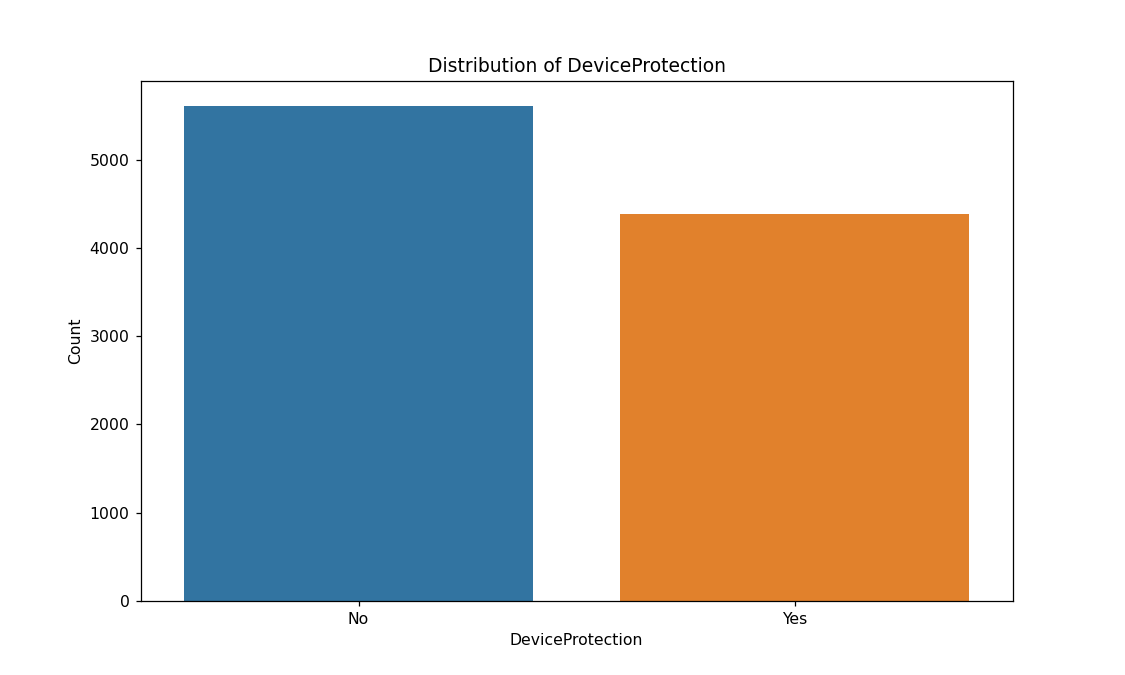

<IPython.core.display.Javascript object>


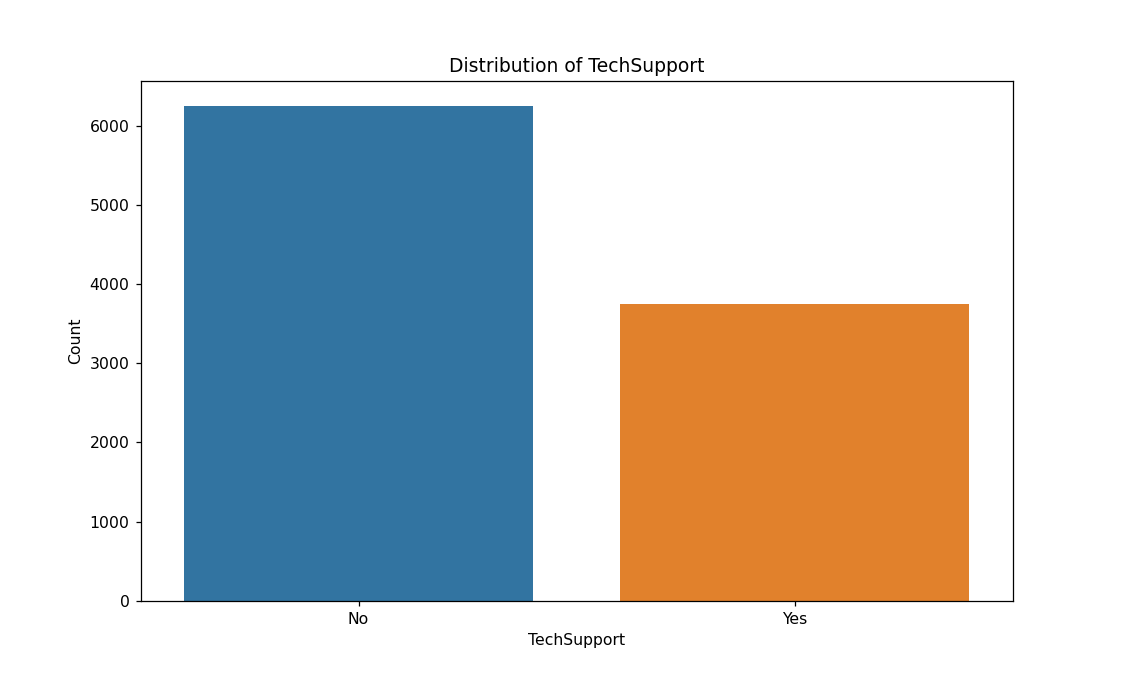

<IPython.core.display.Javascript object>


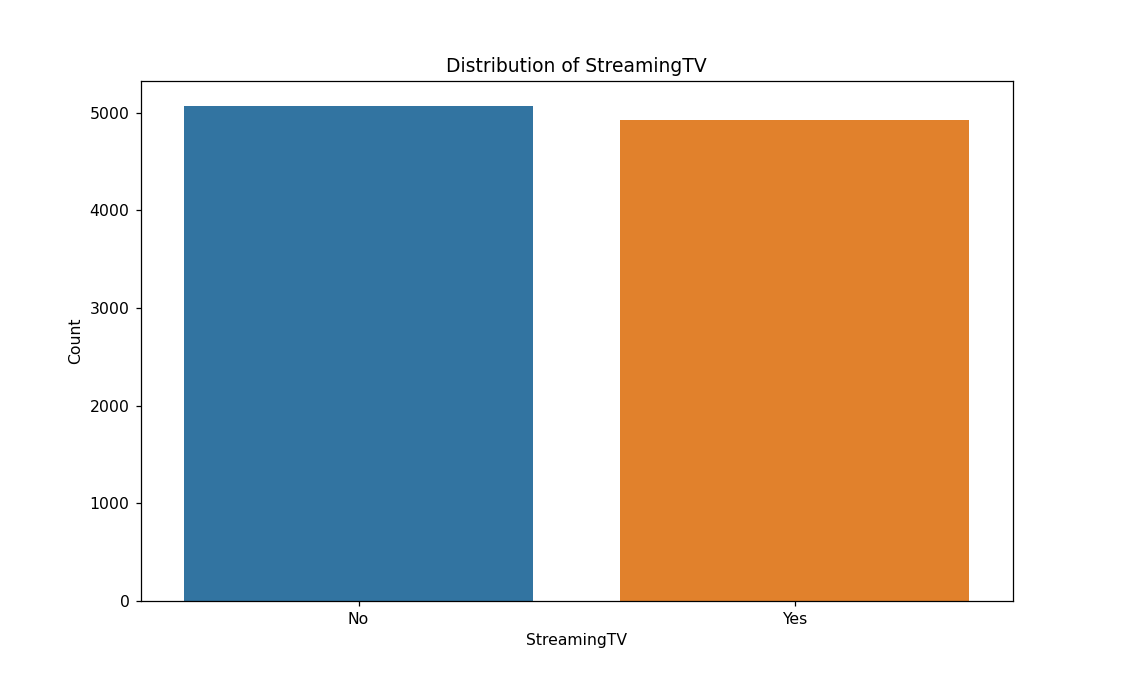

<IPython.core.display.Javascript object>


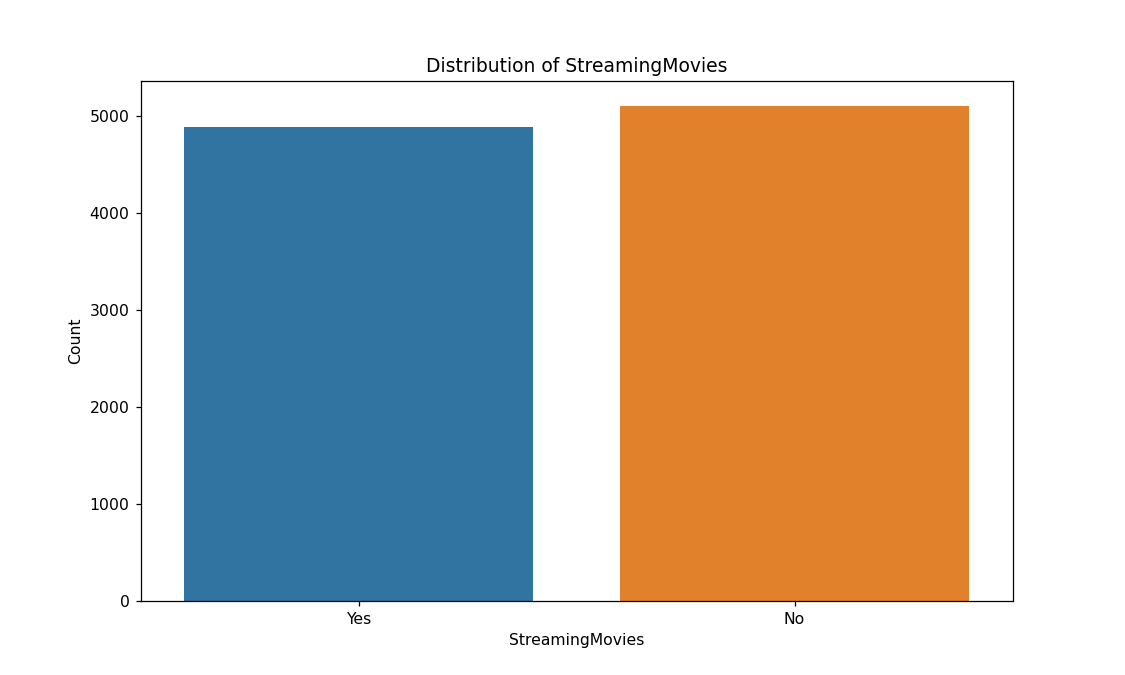

<IPython.core.display.Javascript object>


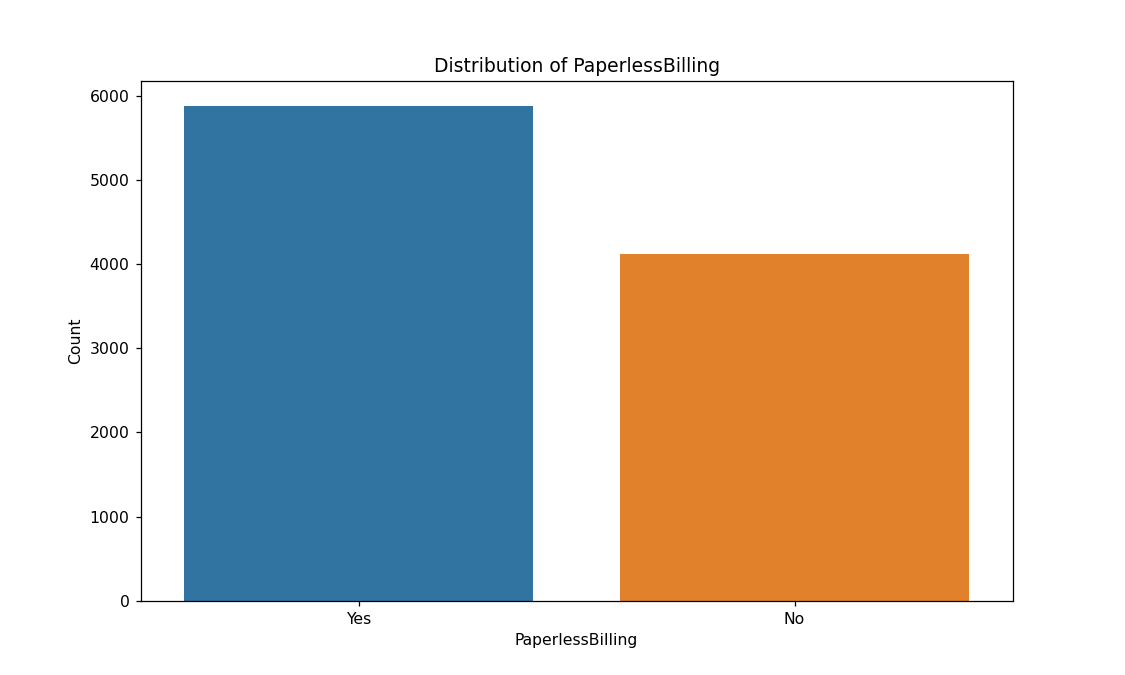

In [22]:
#Plotting bar charts for each encoded categorical variable
for var in encoded_categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, data=data)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

<IPython.core.display.Javascript object>


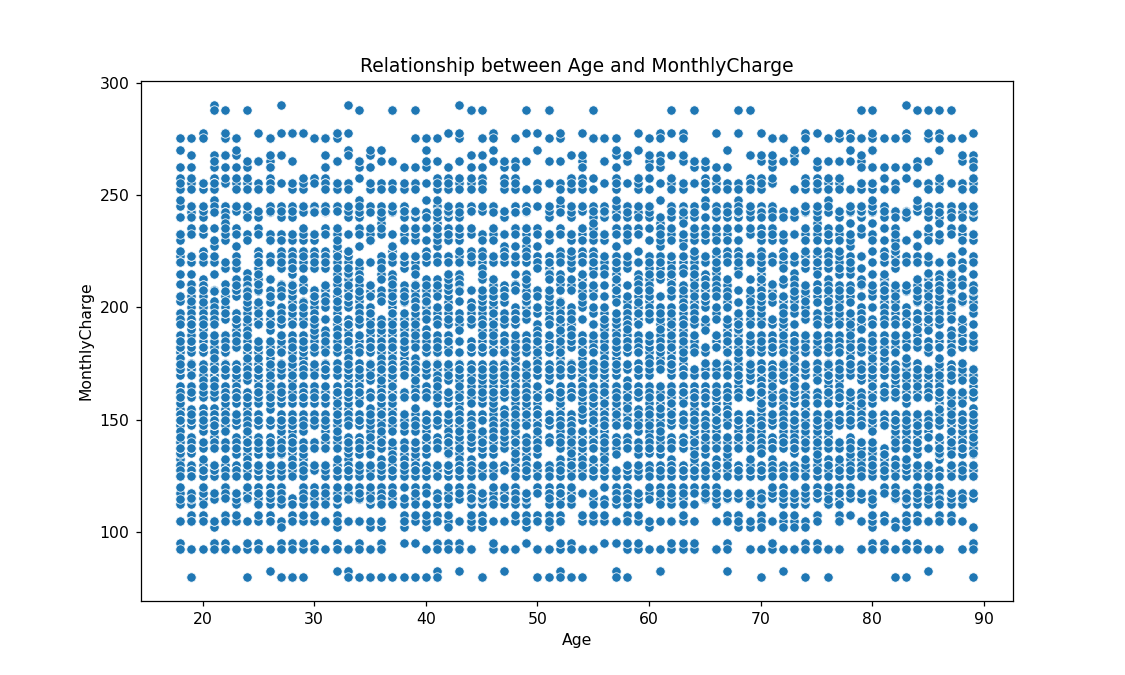

<IPython.core.display.Javascript object>


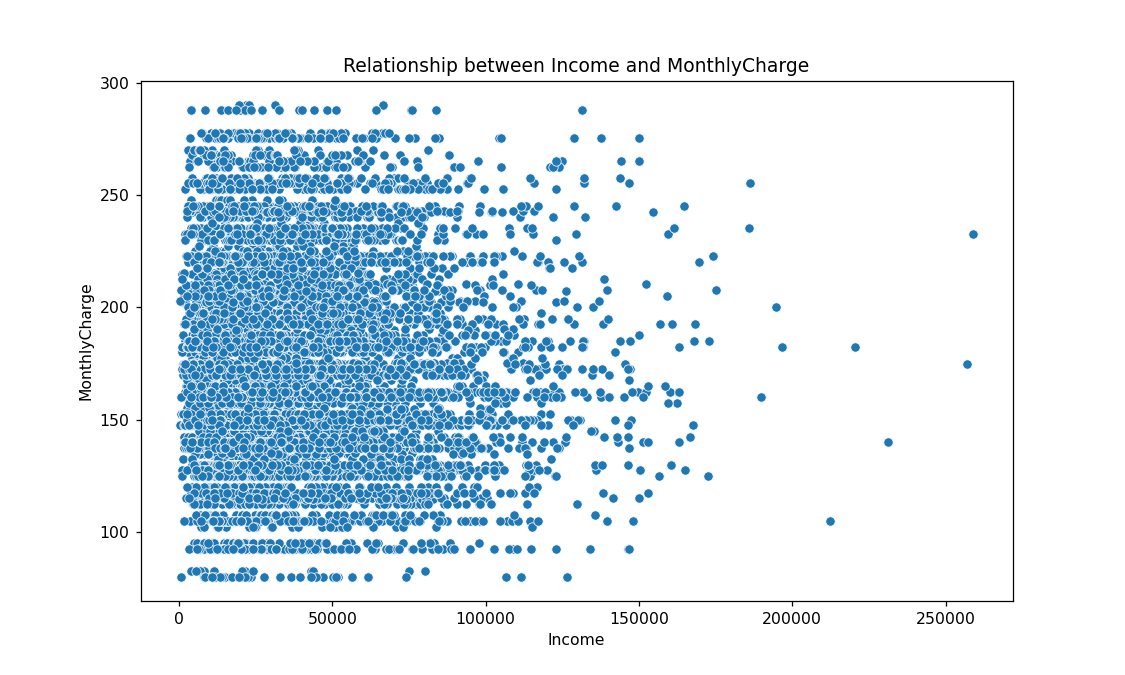

C:\Users\siree\AppData\Local\Temp\ipykernel_1280\1339300489.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


<IPython.core.display.Javascript object>


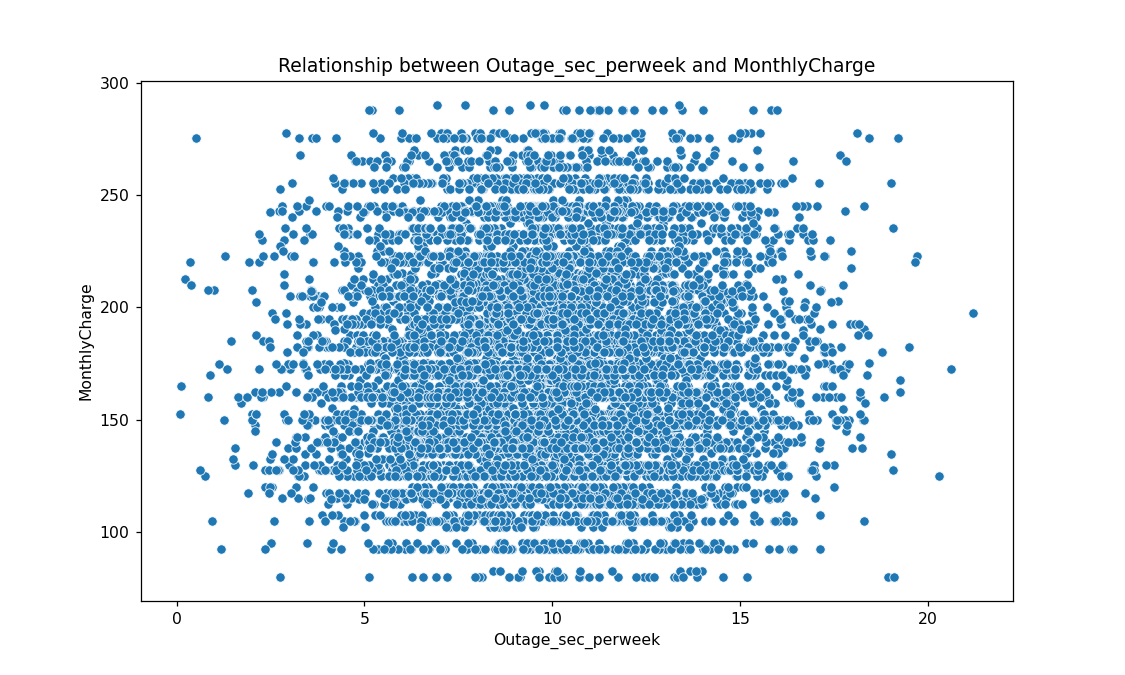

<IPython.core.display.Javascript object>


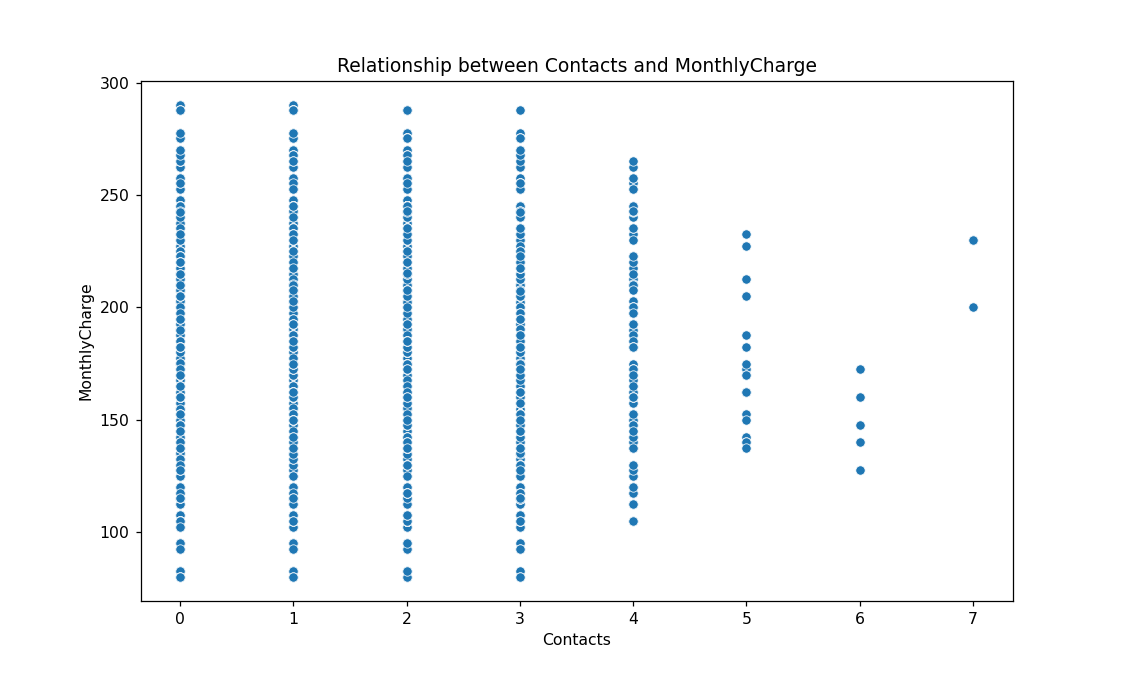

<IPython.core.display.Javascript object>


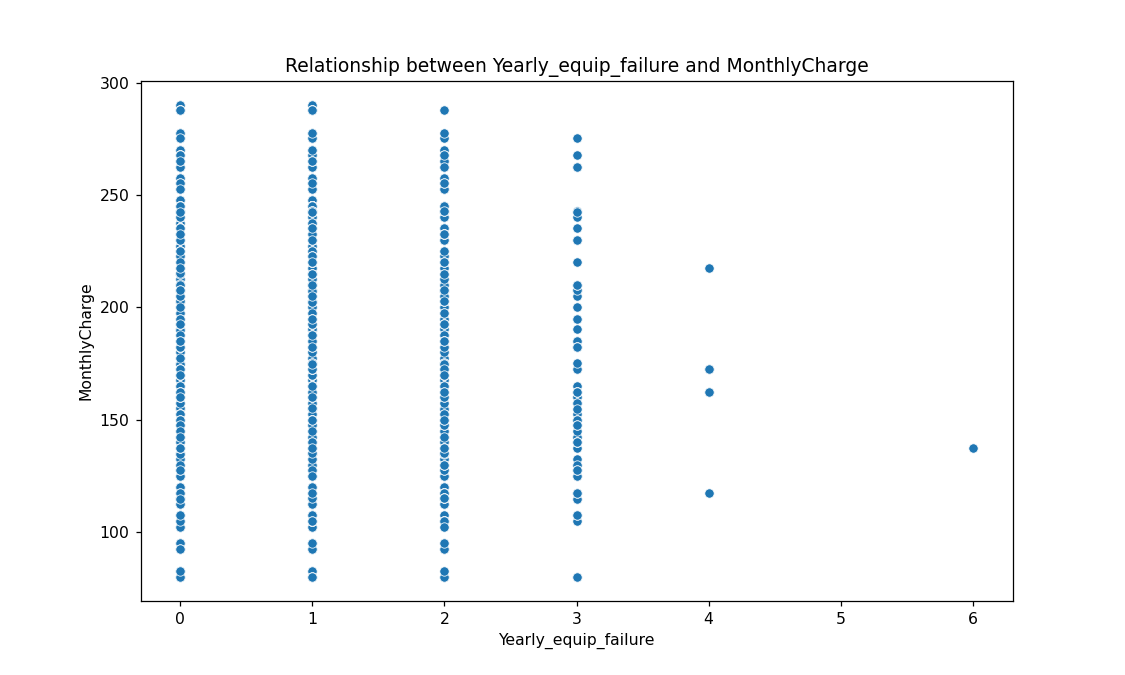

<IPython.core.display.Javascript object>


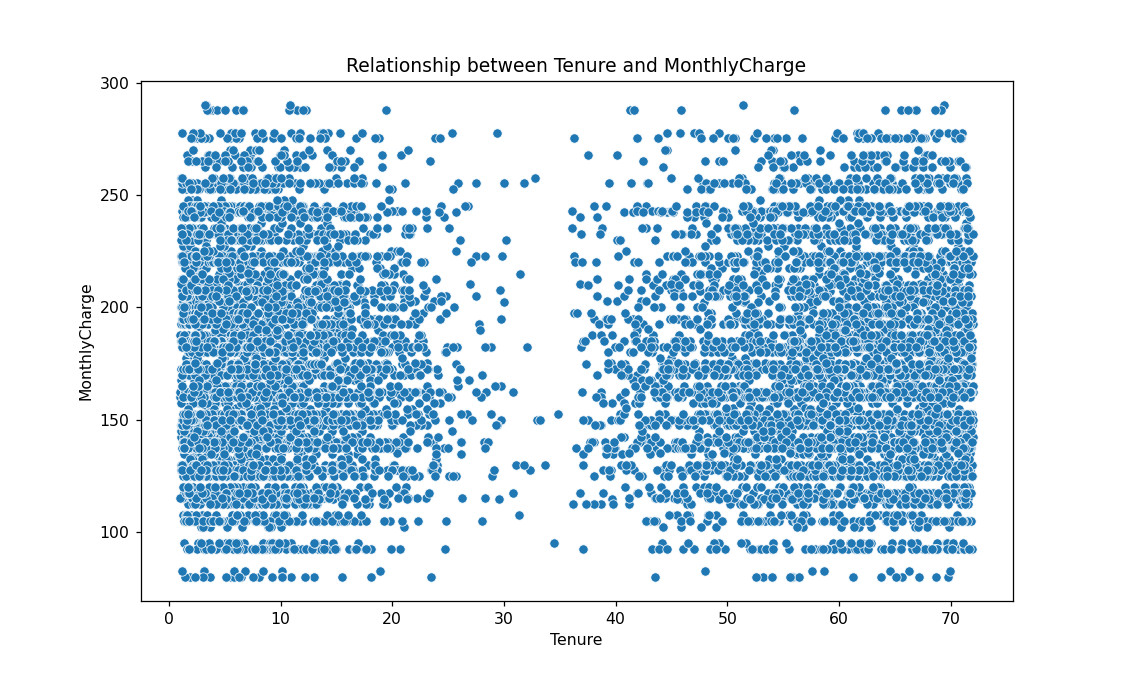

<IPython.core.display.Javascript object>


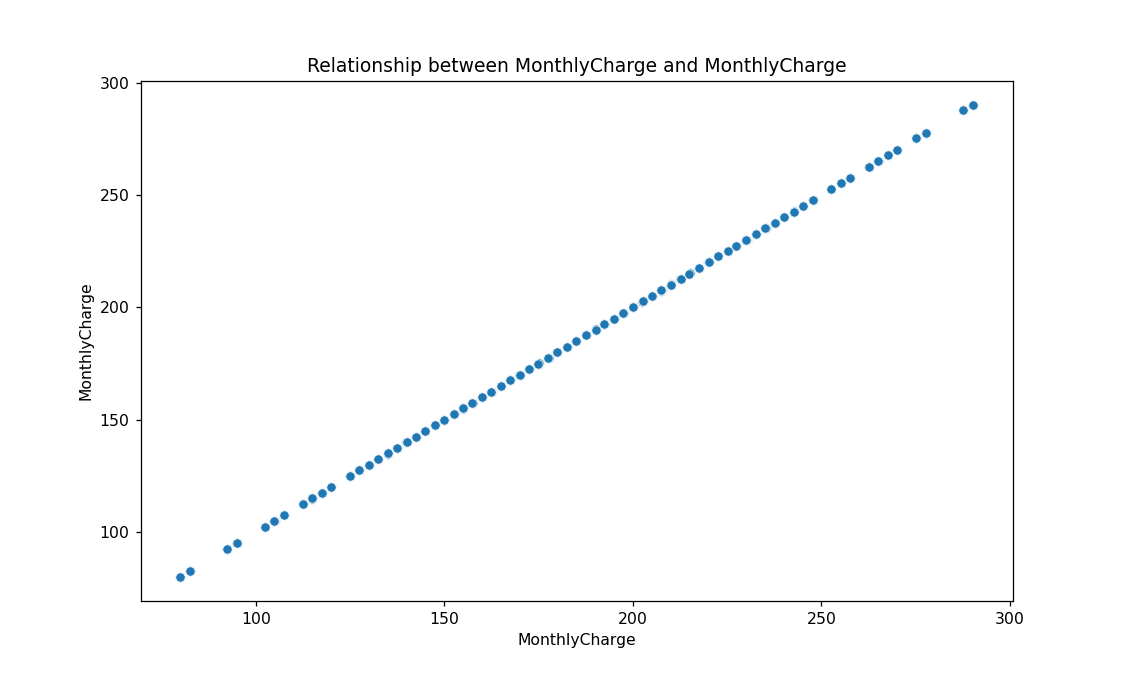

<IPython.core.display.Javascript object>


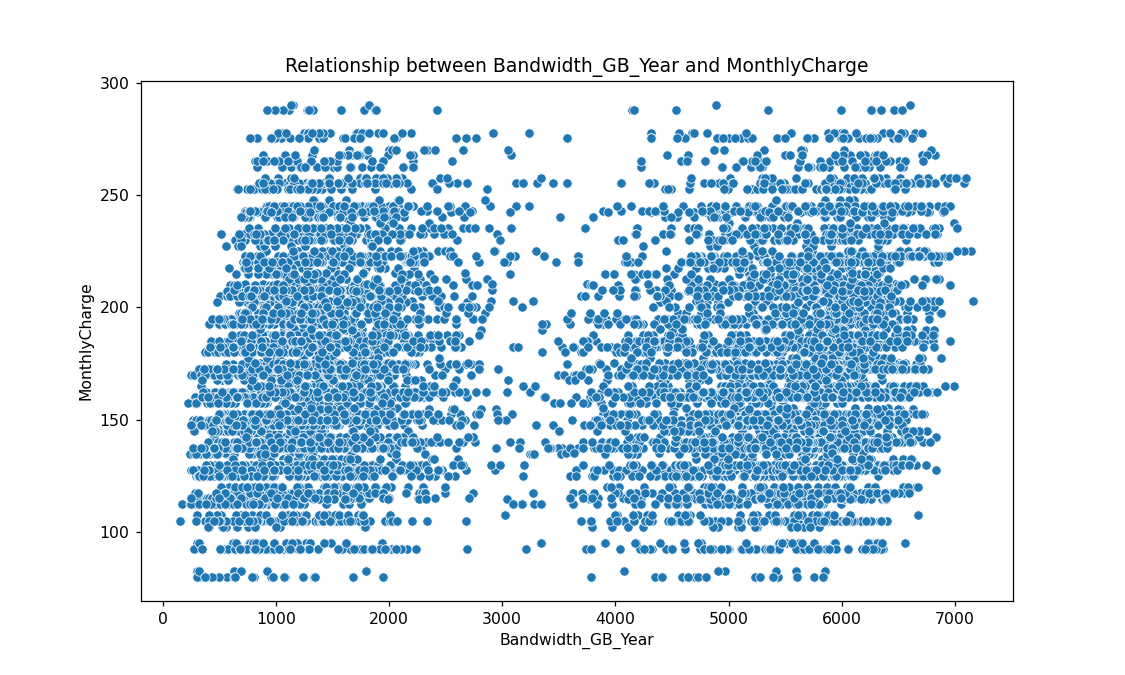

In [23]:
#Bivariate plots for quantitative variables
for var in quantitative_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[var], y=data[dependent_var])
    plt.title(f'Relationship between {var} and {dependent_var}')
    plt.xlabel(var)
    plt.ylabel(dependent_var)
    plt.show()

<IPython.core.display.Javascript object>


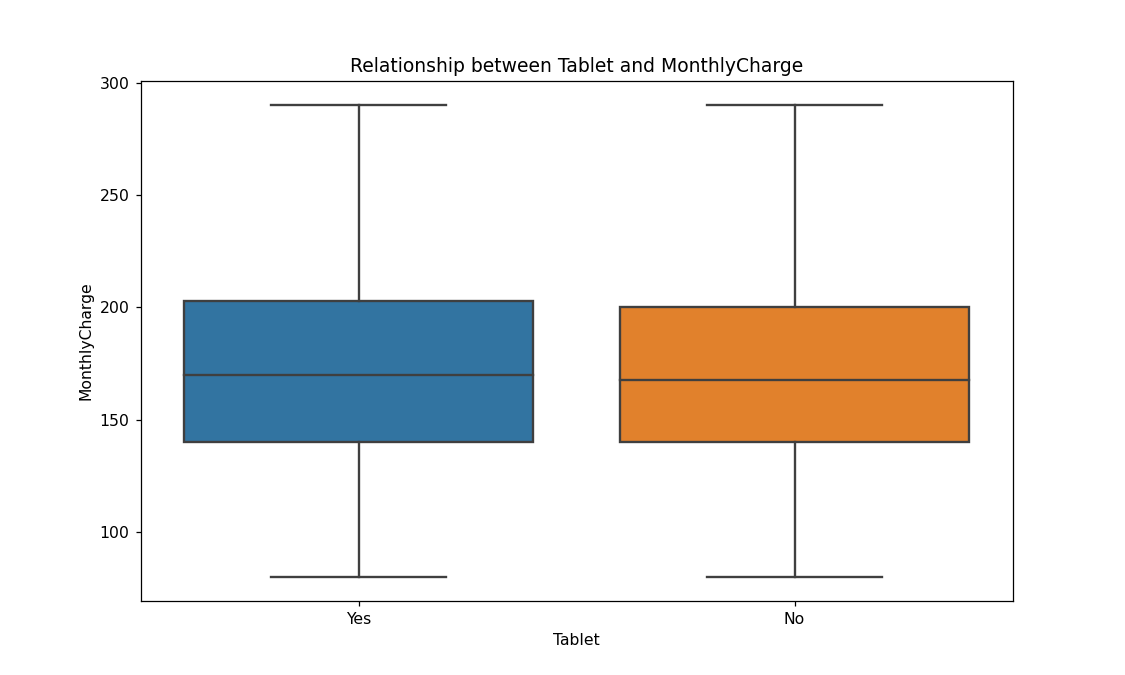

<IPython.core.display.Javascript object>


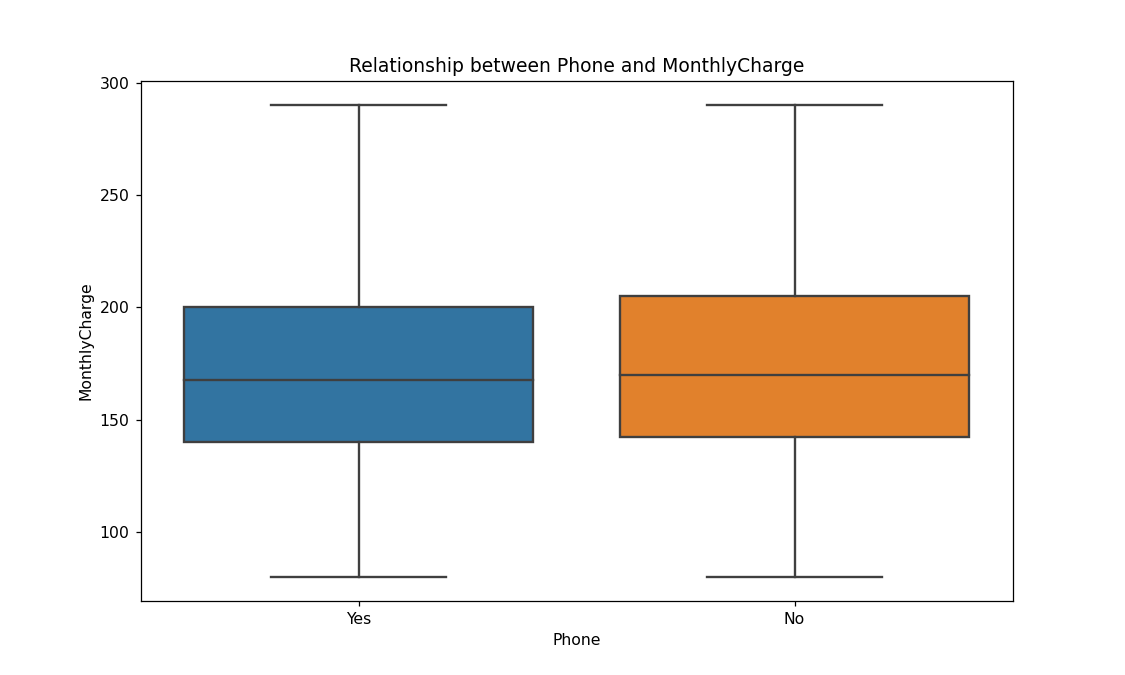

<IPython.core.display.Javascript object>


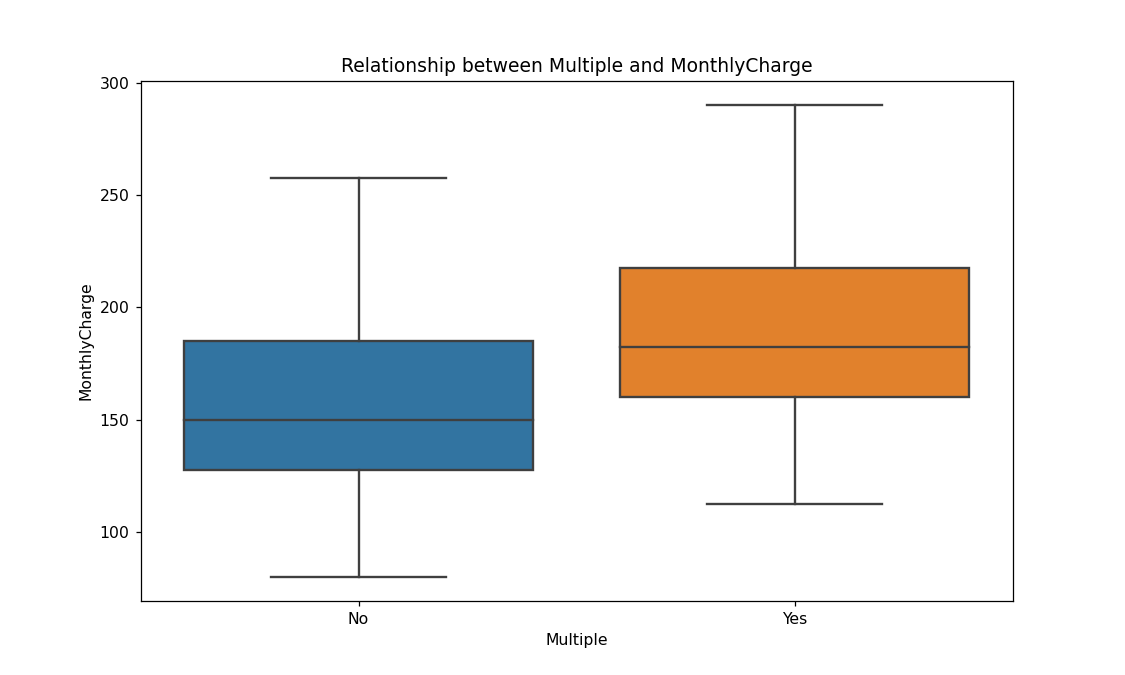

<IPython.core.display.Javascript object>


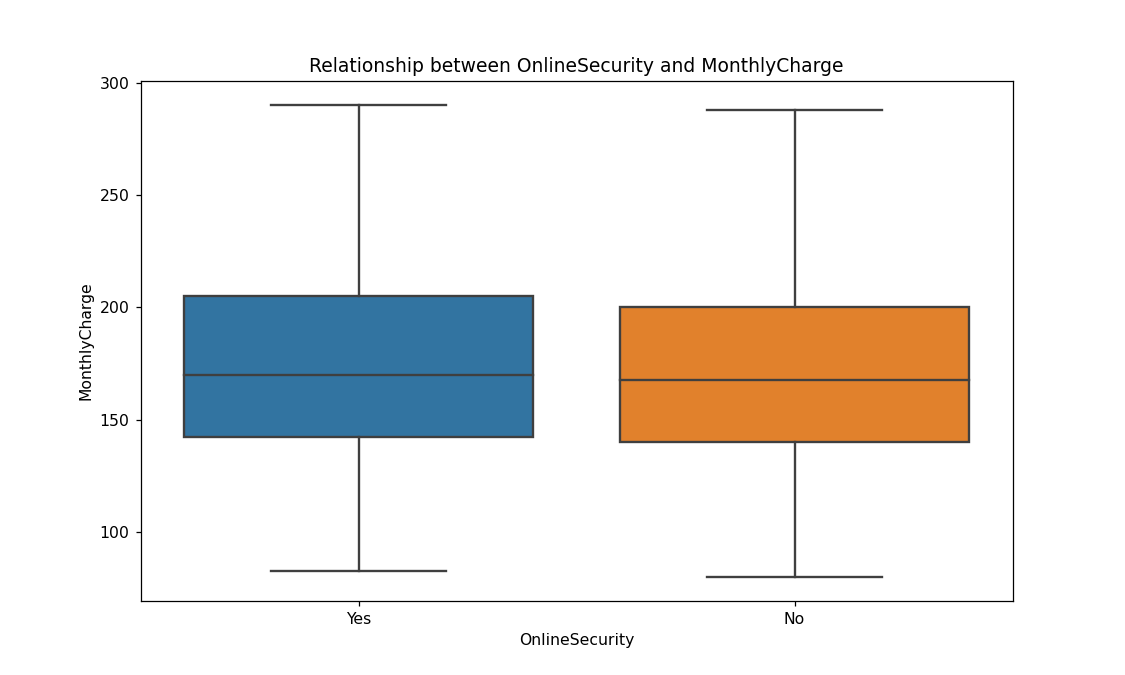

<IPython.core.display.Javascript object>


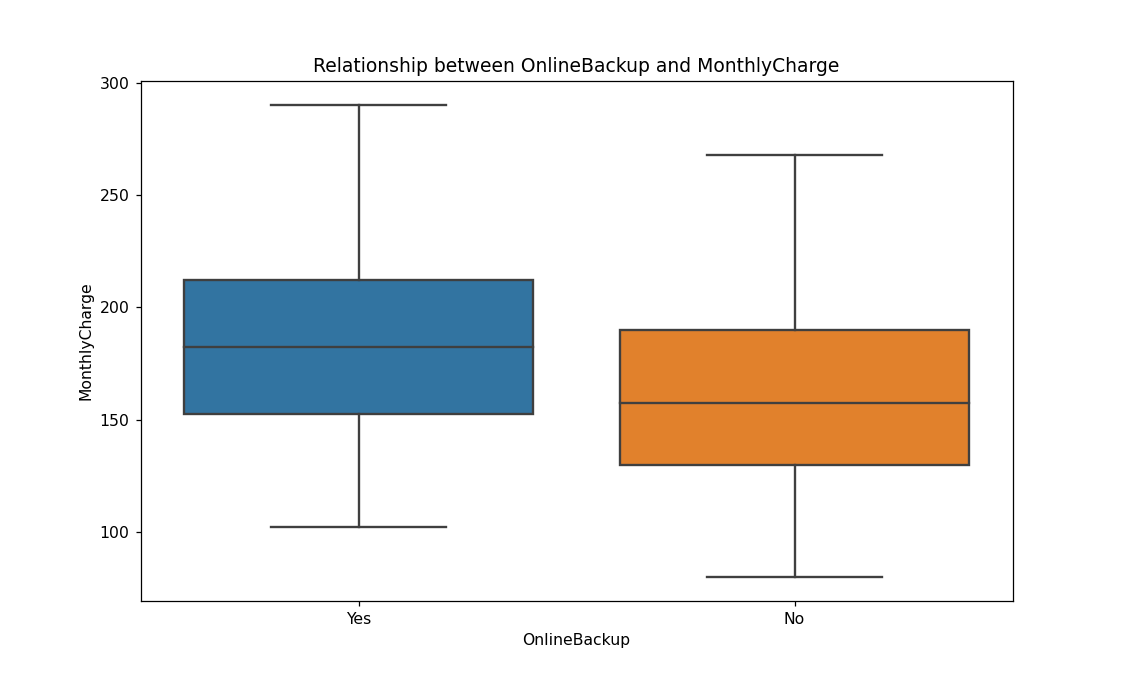

<IPython.core.display.Javascript object>


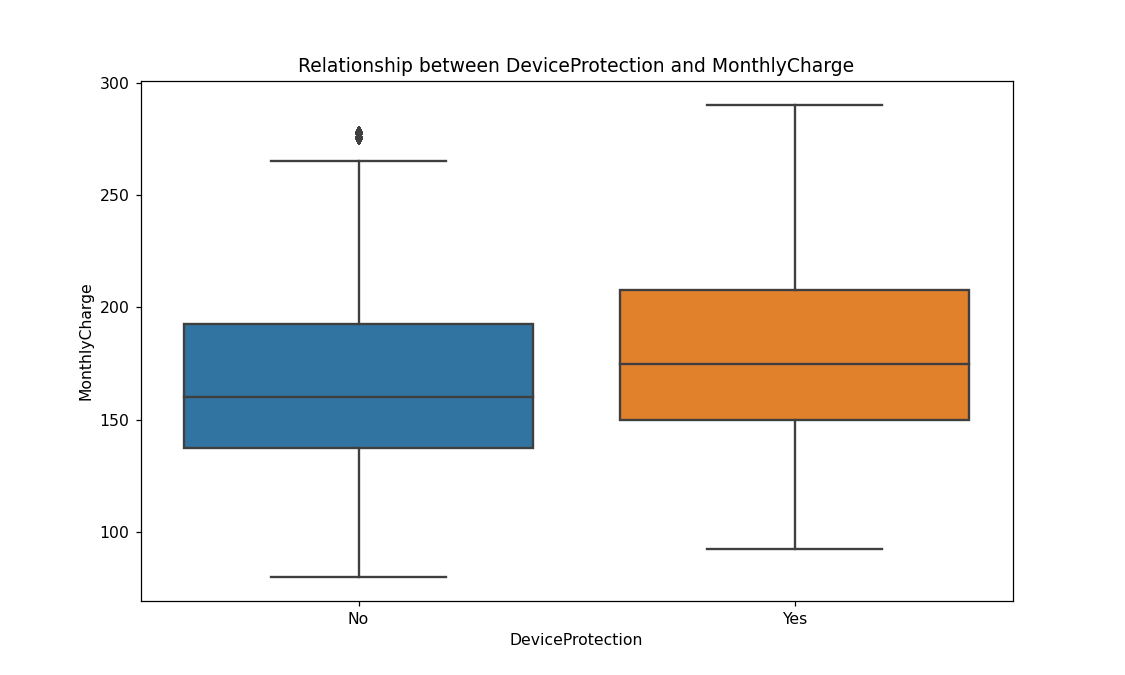

<IPython.core.display.Javascript object>


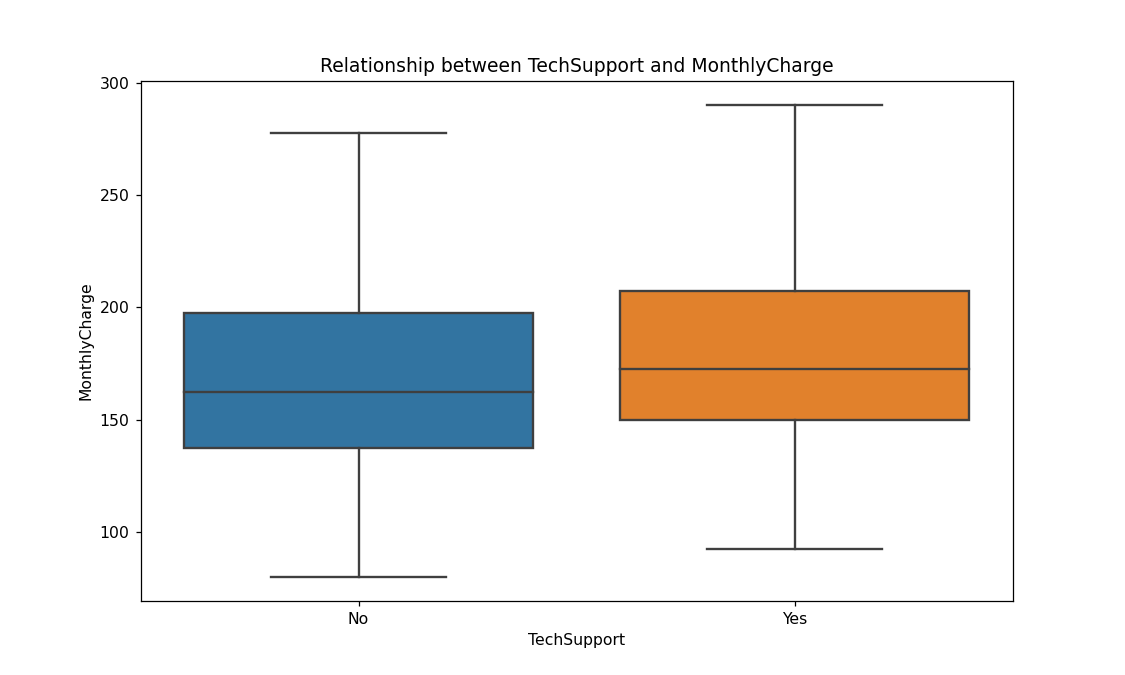

<IPython.core.display.Javascript object>


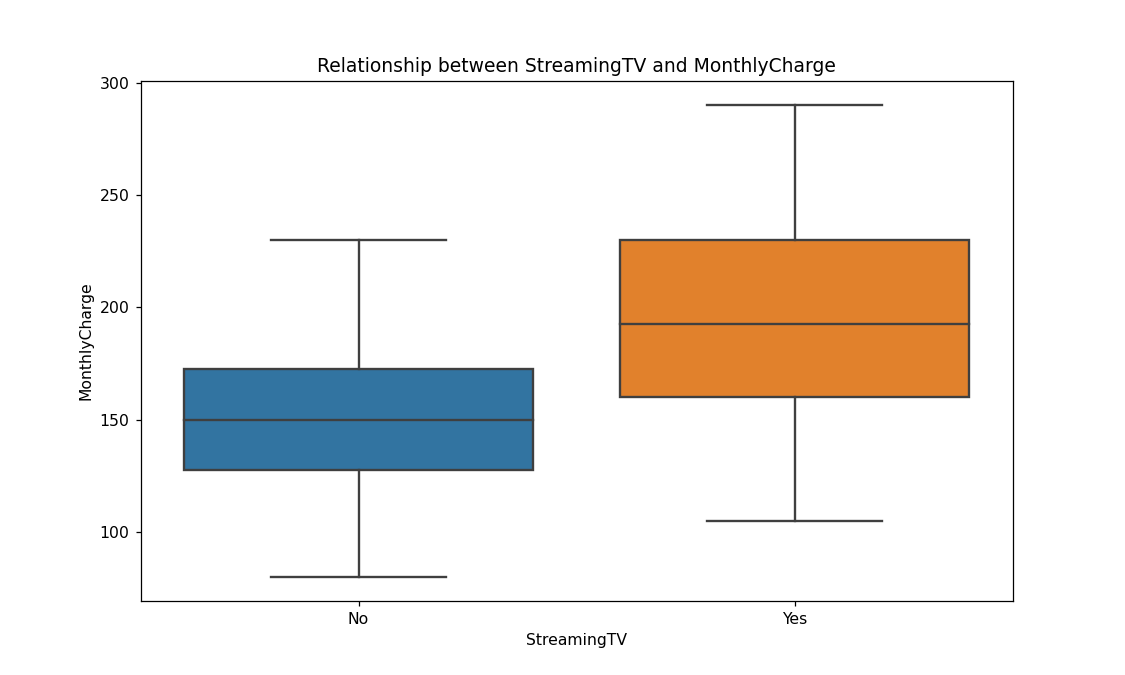

<IPython.core.display.Javascript object>


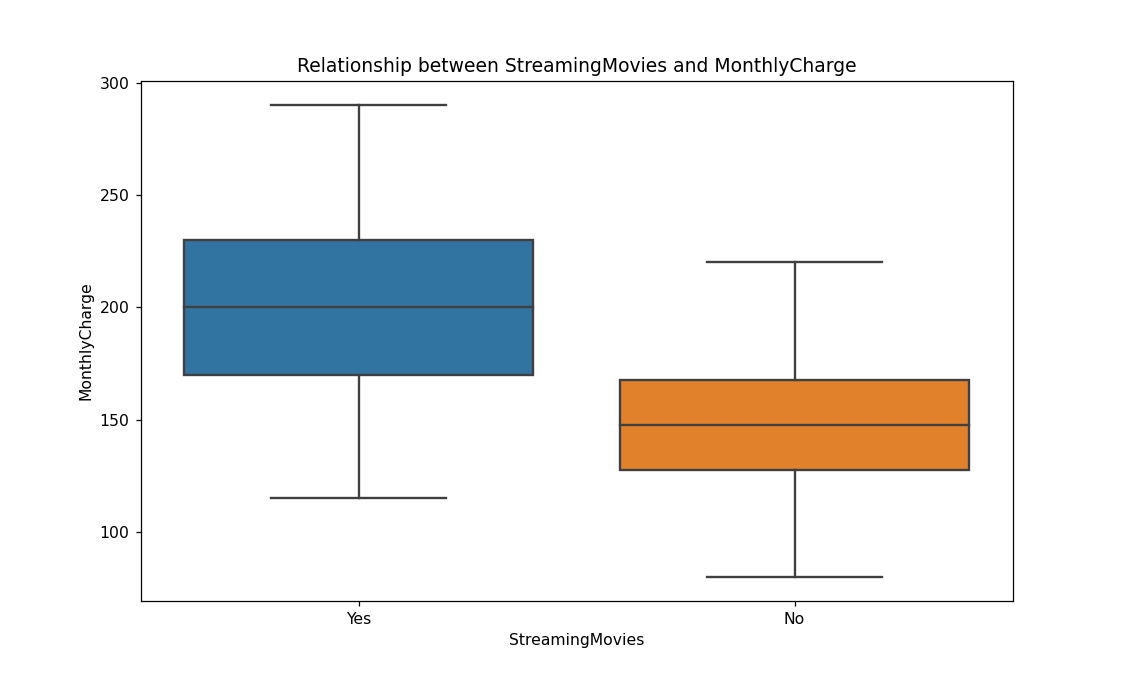

<IPython.core.display.Javascript object>


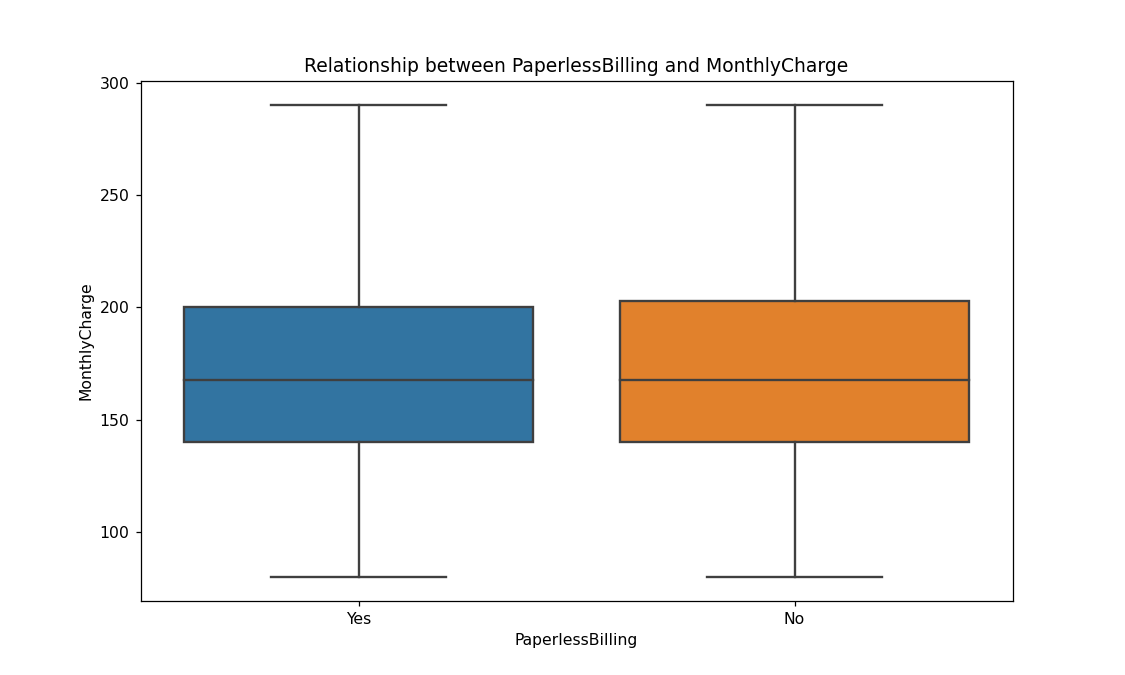

In [24]:
#Bivariate plots for categorical variables
for var in encoded_categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[var], y=data[dependent_var])
    plt.title(f'Relationship between {var} and {dependent_var}')
    plt.xlabel(var)
    plt.ylabel(dependent_var)
    plt.show()

In [ ]:
##### C4: DATA TRANSFORMATION #######

In [25]:
#create dummies
data = pd.get_dummies(data_cleaned, drop_first=True)

In [27]:
#export as a CSV
data.to_csv('C:/Users/siree/OneDrive/Desktop/WGU/D208/TASK_1/SIREEN_SHABAN_D208_TASK1.csv')

In [ ]:
#### D1: INITIL MODEL ######

In [28]:
#Separate features (X) and target variable (y)
X = data.drop(columns=['MonthlyCharge'])
y = data['MonthlyCharge']

In [29]:
#Add constant to the model
X = sm.add_constant(X)

In [30]:
#OLS Regression
model = sm.OLS(y, X).fit()

In [31]:
#summary of the regression
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:          MonthlyCharge   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.343e+04
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:44:14   Log-Likelihood:                -22166.
No. Observations:                8950   AIC:                         4.441e+04
Df Residuals:                    8912   BIC:                         4.468e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
### D3: REDUCED LINEAR REGRESSION MODEL ######

In [32]:
#Separate features (X) and target variable (y)
X = data.drop(columns=['MonthlyCharge'])
y = data['MonthlyCharge']

In [33]:
#linear regression model
lm = LinearRegression()

In [34]:
#Apply RFE
rfe = RFE(estimator=lm, n_features_to_select = 10)
rfe = rfe.fit(X, y)

In [35]:
#select features
selected_features = X.columns[rfe.support_]

In [36]:
#new DataFrame with the selected features
X_reduced = X[selected_features]

In [37]:
#Add constant to the model
X_reduced = sm.add_constant(X_reduced)

In [38]:
#OLS Regression with the reduced set of features
model_reduced = sm.OLS(y, X_reduced).fit()

In [39]:
#summary of the refined regression model
summary_reduced = model_reduced.summary()
print(summary_reduced)

                            OLS Regression Results                            
Dep. Variable:          MonthlyCharge   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 2.070e+04
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:45:19   Log-Likelihood:                -32108.
No. Observations:                8950   AIC:                         6.424e+04
Df Residuals:                    8939   BIC:                         6.432e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
#### E2: OUTPUT AND CALCULATIONS ######

In [40]:
#Get the residuals
residuals = model_reduced.resid

<IPython.core.display.Javascript object>


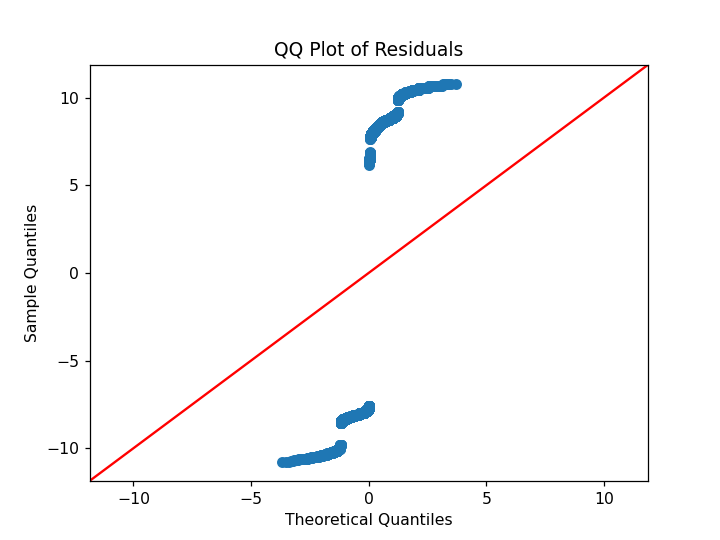

In [41]:
#visualization QQ Plot
sm.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

<IPython.core.display.Javascript object>


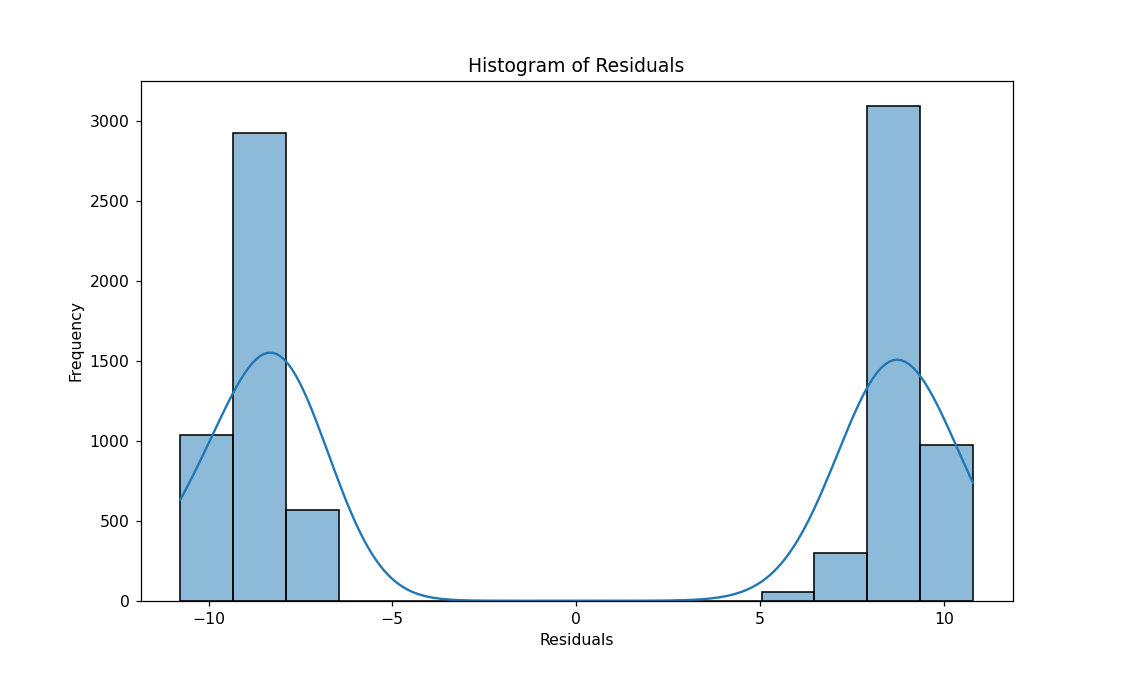

In [42]:
#Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [43]:
#RSE
residual_standard_error = model_reduced.scale ** 0.5
print(f"Residual Standard Error: {residual_standard_error}")

Residual Standard Error: 8.751055591455062
